# Beta-binomial hierarchical model for batting averages

In Lec20, which introduced the notion of **shrinkage**, we discussed the Efron & Morris (EM) demonstration of shrinkage using data on the batting averages for baseball players.  EM computed their shrinkage estimates using an analytical formula appropriate for data with additive errors whose probability distributions are IID *normal*.  To make this work, they used a nonlinear *variance stabilizing transformation* of the reported averages (ratios of counts); this makes the distribution for the transformed data approximately normal.

Here, we'll treat the data without such an approximation, using a beta-binomial hierarchical model.

In [1]:
from io import StringIO

import pandas as pd  # we'll use Pandas to read and parse the data
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib.pyplot import *
from numpy import *
from scipy import stats

from stanfitter import StanFitter
# Plotting helper:
from shrinkage_plot import shrinkage_plot

In [2]:
# Efron-Morris baseball data in CSV format:
csv_data = StringIO("""
Player,First45,Remainder, JS
Clemente, 0.400, 0.346, 0.290
F.~Robinson, 0.378, 0.298, 0.286
F.~Howard, 0.356, 0.276, 0.282
Johnstone, 0.333, 0.222, 0.277
Berry, 0.311, 0.273, 0.273
Spencer, 0.311, 0.270, 0.273
Kessinger, 0.289, 0.263, 0.268
Alvarado, 0.267, 0.210, 0.264
Santo, 0.244, 0.269, 0.259
Swoboda, 0.244, 0.230, 0.259
Unser, 0.222, 0.264, 0.254
Williams, 0.222, 0.256, 0.254
Scott, 0.222, 0.303, 0.254
Petrocelli, 0.222, 0.264, 0.254
Rodriguez, 0.222, 0.226, 0.254
Campaneris, 0.200, 0.285, 0.249
Munson, 0.178, 0.316, 0.244
Alvis, 0.156, 0.200, 0.239
""")

bbdata = pd.read_csv(csv_data)
bbdata

,Player,First45,Remainder,JS
0,Clemente,0.400,0.346,0.290
1,F.~Robinson,0.378,0.298,0.286
2,F.~Howard,0.356,0.276,0.282
3,Johnstone,0.333,0.222,0.277
4,Berry,0.311,0.273,0.273
5,Spencer,0.311,0.270,0.273
6,Kessinger,0.289,0.263,0.268
7,Alvarado,0.267,0.210,0.264
8,Santo,0.244,0.269,0.259
9,Swoboda,0.244,0.230,0.259


In [3]:
n_players = len(bbdata)

# Number of at-bats for First45:
n_at_bat = 45

# Numbers of hits for First45:
n_hits = round(n_at_bat*bbdata['First45'])
n_hits = array(n_hits, dtype=int)
n_players, n_hits

(18,
 array([18, 17, 16, 15, 14, 14, 13, 12, 11, 11, 10, 10, 10, 10, 10,  9,  8,
         7]))

## Parameterization for the beta population distribution

We'll adopt a beta distribution as the population distribution for the batting averages.

Denoting the batting average (as a fraction) for player $i$ by $\alpha_i$ (it will be `bavgs[i]` in the code), the usual $(a,b)$ parameterization of the beta distribution would give the population distribution as
$$
p(\alpha_i|a,b) = \frac{1}{B(a,b)} \alpha_i^{a-1} (1-\alpha_i)^{b-1},
$$
where $B(a,b)$ denotes the beta integral, serving as a normalization constant.

We'll instead adopt a more interpretable parameterization, using the population distribution mean, $\mu$, and a parameter related to the standard deviation, $\sigma$, as parameters.  Recall that these moments are related to $(a,b)$ as follows:
\begin{align}
\mu &= \frac{a}{a+b},\\
\sigma^2 &= \frac{a b}{(a+b)^2 (a+b+1)} = \frac{\mu(1-\mu)}{a+b+1}.
\end{align}
In place of $\sigma$, we'll instead use a simple *concentration* parameter, $\kappa$, which is approximately equal to the precision, $1/\sigma^2$:
$$
\kappa \equiv a + b.
$$
If we specify $(\mu,\kappa)$, we'll need expressions for $a$ and $b$ in terms of them. A bit of algebra yields:
\begin{align}
a &= \kappa\mu,\\
b &= \kappa (1-\mu).
\end{align}
The following code defines functions implementing these transformations, and doing a quick consistency check of the functions.

In [4]:
def moments2ab(mu, sig):
    """
    Return the beta dist'n (a,b) params given the mean and std dev'n
    of alpha, `mu` and `sig`.
    """
    a = mu*(mu*(1.-mu)/sig**2 - 1.)
    b = a*(1.-mu)/mu
    return a, b

def ab2moments(a, b):
    """
    Return the mean and std dev'n of alpha for a beta dist'n with
    shape params `a` and `b`.
    """
    return a/(a+b), sqrt(a*b/((a+b)**2 * (a+b+1.)))

def test_trans_moments(a,b):
    print('\na,b:', a, b)
    print('Moments:', ab2moments(a,b))
    print('a,b:', moments2ab(*ab2moments(a,b)))

test_trans_moments(1,1)
test_trans_moments(.5,.5)
test_trans_moments(30,70)


a,b: 1 1
Moments: (0.5, 0.28867513459481287)
a,b: (1.0, 1.0)

a,b: 0.5 0.5
Moments: (0.5, 0.3535533905932738)
a,b: (0.4999999999999998, 0.4999999999999998)

a,b: 30 70
Moments: (0.3, 0.045598332434334476)
a,b: (29.999999999999993, 69.99999999999999)


In [5]:
def params2ab(mu, kappa):
    """
    Return the beta dist'n (a,b) params given the mean and concentration
    params, `mu` and `kappa`.
    """
    a = mu*kappa
    b = (1.-mu)*kappa
    return a, b

def ab2params(a, b):
    """
    Return the mean and concentration params for a beta dist'n with
    shape params `a` and `b`.
    """
    return a/(a+b), a + b

def test_trans_ab(a,b):
    print('\na,b:', a, b)
    print('mean, conc.:', ab2moments(a,b))
    print('a,b:', moments2ab(*ab2moments(a,b)))

test_trans_ab(1,1)
test_trans_ab(.5,.5)
test_trans_ab(30,70)


a,b: 1 1
mean, conc.: (0.5, 0.28867513459481287)
a,b: (1.0, 1.0)

a,b: 0.5 0.5
mean, conc.: (0.5, 0.3535533905932738)
a,b: (0.4999999999999998, 0.4999999999999998)

a,b: 30 70
mean, conc.: (0.3, 0.045598332434334476)
a,b: (29.999999999999993, 69.99999999999999)


## Prior for the beta population distribution parameters

We'll adopt a prior for $(\mu,\kappa)$ that aims to be uninformative, i.e., to allow diverse beta distributions a priori.  From the formulas for $\mu$ and $\kappa$, note that they are necessarily related, in that 

We'll adopt a flat prior for $\mu$ over nearly its full $[0,1]$ range, making it flat over the interval $[\mu_l=0.05, \mu_u=0.95]$.  We avoid setting $\mu_l = 0$ or $\mu_u=1$, firstly because we don't believe it all likely that *every* player is a perfect hitter ($\mu=1,\sigma=0$) or a perfectly *bad* hitter ($\mu=0,\sigma=0$). Also, when $\mu$ is at or near one 0 or 1, the population distribution becomes nearly divergent; setting bounds away from these troublesome points will avoid potential numerical problems with handling nearly degenerate distributions.

For $\kappa$, the Gelman et al. *BDA* book recommends adopting a prior that is approximately uniform in $1/\sqrt{\kappa}$, i.e., roughly uniform in $\sigma$. Recall that $\kappa$ is a *hyperparameter*, and thus only indirectly tied to the data (via a layer of latent batting average parameters). This means that hyperparameters tend to be less strongly constrained than parameters directly tied to data in the model's DAG. As a result *posterior propriety* can be a delicate issue for hierarchical models—"uninformative" improper priors that work fine in simpler models can produce *improper posteriors* in hierarchical settings. Problem 9 in Chapter 5 of *BDA* explores this for the beta-binomial model, showing that a $1/\sigma$ prior (which is fine for a normal standard deviation) produces an improper posterior. The flat prior works fine.

A change-of-variables calculation shows that a prior that is uniform in $1/\sqrt{\kappa}$ correspondes to a power-law or *Pareto* distribution for $\kappa$ itself:
$$
\pi(\kappa) \propto \frac{1}{\kappa^{\alpha+1}}.
$$
A uniform prior for $1/\sqrt{\kappa}$ strictly corresponds to $\alpha=1/2$. The *Stan User's Guide* recommends using $\alpha=3/2$; see [21.2 Reparameterizations | Stan User’s Guide](https://mc-stan.org/docs/2_21/stan-users-guide/reparameterizations.html). 

Let's look at what various choices imply for choices of beta distributions.  We'll keep track of how many prior samples have $a>1$ and $b>1$; these are cases that don't peak at a boundary, which are the most reasonable cases.  We'll also cut off very small $\kappa$ values (corresponding to very sharp population distributions that could cause numerical issues).

Positive exponent cases: 27 0.27


(0.0, 20.0)

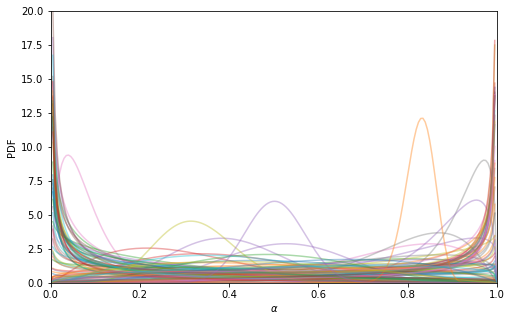

In [6]:
mu_l=0.05
mu_u=0.95
dmu = mu_u - mu_l

figure(figsize=(8,5))
alphas = linspace(0., 1., 200)
npos = 0  # count cases with a, b >= 1
ncases = 100
# ab1 = smallest allowed value of a+b+1
ab1 = 3  # **EXPERIMENT WITH THIS**
for i in range(ncases):
    mu = stats.uniform(mu_l, dmu).rvs()
    kappa = stats.pareto(1., loc=0.1).rvs()  # experiment with the index
    a, b = params2ab(mu, kappa)
    # Count cases that peak inside the interval.
    if a >= 1. and b >= 1.:
        npos += 1
    pdf = stats.beta(a,b).pdf(alphas)
    plot(alphas, pdf, '-', alpha=.4)
print('Positive exponent cases:', npos, npos/ncases)
xlabel(r'$\alpha$')
ylabel('PDF')
xlim(0., 1.)
ylim(0., 20.)

Based on experiments, I'm choosing to use $\alpha=1$ in the Stan code below.

## Stan code for a beta-binomial hierarchical model

Note the use of a `transforme parameters` block in this model, to transform between our parameterization and what Stan needs for the beta distribution.

In [7]:
bb_code = """
data {
    int<lower=0> n_players; 
    int n_at_bat;
    int<lower=0> hits[n_players];

    real<lower=0> mu_l;  // mean batting avg lower limit
    real<lower=0> mu_u;  // mean batting avg upper limit
    real<lower=1> ab1;   // lowest allowed value of beta a+b+1
} 

parameters {
    real<lower=0,upper=1> mu;  // mean batting avg
    real<lower=0> kappa; // concentration in batting avgs
    real<lower=0,upper=1> bavgs[n_players];
}

transformed parameters {
  real<lower=0> a = kappa * mu;
  real<lower=0> b = kappa * (1 - mu);
}

model {
    mu ~ uniform(mu_l, mu_u);  // flat hyperprior
    kappa ~ pareto(0.1, 1.);
    // print("mu=", mu, " sig=", sig);
    // print("a=", a, " b=", b);

    for (i in 1:n_players){
        bavgs[i] ~ beta(a, b);
        hits[i] ~ binomial(n_at_bat, bavgs[i]);
    }
}
"""

## Stan fits

Finally we can do some fits!

In [8]:
# Invoke Stan to build the model, caching the built model in the CWD to save
# time if the script is re-run without any Stan code changes.
# bb_fitter = StanFitter(bb_code, name='Baseball')
bb_fitter = StanFitter(bb_code, name='Baseball_mu_kappa')

Using cached StanModel from cached-model-Baseball_mu_kappa-f8e141098b0f6093285a33e669ccbbc8.pkl...


In [9]:
bb_data = dict(n_players=n_players, n_at_bat=n_at_bat, hits=n_hits,
               mu_l=mu_l, mu_u=mu_u, ab1=3.)
# bb_data = dict(n_players=n_players, n_at_bat=n_at_bat, hits=n_hits, ab_max=200.)
bb_fitter.set_data(bb_data)

In [10]:
n_iter, n_chains = 10000, 4
bb_fit = bb_fitter.sample(n_iter, n_chains, control={'adapt_delta': 0.95})


Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)

Gradient evaluation took 6.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)

Gradient evaluation took 0.000109 seconds

Gradient evaluation took 0.000119 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.19 seconds.
1000 transitions using 10 leapfrog steps per transition would take 1.09 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!




Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 

Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 1.67 seconds (Warm-up)
               1.54979 seconds (Sampling)
               3.21979 seconds (Total)



Stan may sometime report problems with "divergence"—the sampler encountering regions of strongly varying curvature that are difficult to fully explore with a single optimum step size. This results in chains that approach equilibrium too slowly, and indicates you should carefully look at the results (esp. ESS and trace plots) for evidence that some parameters are poorly sampled.  If the fraction of divergent iterations is more than a few percent,  attention is warranted.

First try increasing the `adapt_delta` control parameter for Stan to a value closer to 1 than StanFitter's default of 0.95 (this will shrink the HMC proposal step size; see the `sample` method docstring), and run longer chains (if possible). If that doesn't help, the problem may need to be reparameterized, or the prior may need adjustment if the poorly sampled regions are uninteresting. For discussion of this, see: [Diagnosing Biased Inference with Divergences](https://betanalpha.github.io/assets/case_studies/divergences_and_bias.html).

Stan may also report that the `E-BFMI` (Energy Bayesian Fraction of Missing Information) may be too small for one or more chains. This, too, is a diagnostic of how rapidly the chain is being explored. It measures how effectively resampling the auxiliary momentum variables in the HMC algorithm helps the sampler move around the parameter space; values much less than 0.2 indicate slow exploration (empirically). As with divergences, adjusting the prior to screen off uninteresting regions that aren't well-constrained by the data may help.  Otherwise, reparameterization may be necessary.

For more on these issues, see:
* [[1701.02434] A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434)
* [Robust Statistical Workflow with PyStan](https://betanalpha.github.io/assets/case_studies/pystan_workflow.html) — A case study where these issues arise, showing how to use an external package, `stan_utility`, to diagnose problems
* [Diagnosing Biased Inference with Divergences](https://betanalpha.github.io/assets/case_studies/divergences_and_bias.html) — A more extensive case study
* [[1604.00695] Diagnosing Suboptimal Cotangent Disintegrations in Hamiltonian Monte Carlo](https://arxiv.org/abs/1604.00695) — Discusses the divergence diagnostic
* [[1312.0906] Hamiltonian Monte Carlo for Hierarchical Models](https://arxiv.org/abs/1312.0906) — Discusses reparameterization
* [[0708.3797] A General Framework for the Parametrization of Hierarchical Models](https://arxiv.org/abs/0708.3797) — Discusses reparameterization

In [11]:
print(bb_fit.mu)
print(bb_fit.kappa)

Parameter <mu> summary:
Convergence and mixing diagnostics:  Rhat = 1.00, ESS = 7406
Mean (se), median, sd:  0.267 (0.000229),  0.267,  0.0197
Central intvls:  50%: [0.254, 0.28];  95%: [0.23, 0.308]

Parameter <kappa> summary:
Convergence and mixing diagnostics:  Rhat = 1.01, ESS = 1000
Mean (se), median, sd:  197 (10.9),  93.4,  346
Central intvls:  50%: [52.5, 189];  95%: [20.8, 1.12e+03]



In [12]:
print(bb_fit)

PyStan's fit summary:
[*** NOTE: PyStan uses 1-based array indexing here! ***]

Inference for Stan model: anon_model_f8e141098b0f6093285a33e669ccbbc8.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu          0.27  2.3e-4   0.02   0.23   0.25   0.27   0.28   0.31   7407    1.0
kappa     197.21   10.94 345.84  20.78  52.47  93.44 189.19 1124.7   1000   1.01
bavgs[1]    0.31  6.3e-4   0.05   0.23   0.28    0.3   0.34   0.42   5929    1.0
bavgs[2]     0.3  5.2e-4   0.05   0.23   0.27    0.3   0.33   0.41   7978    1.0
bavgs[3]     0.3  4.7e-4   0.04   0.22   0.27   0.29   0.32    0.4   9211    1.0
bavgs[4]    0.29  3.8e-4   0.04   0.21   0.26   0.28   0.31   0.39  12594    1.0
bavgs[5]    0.28  3.6e-4   0.04   0.21   0.25   0.28   0.31   0.37  14065    1.0
bavgs[6]    0.28  3.5e-4   0.04   0.21   0.25   0.28   0.31   0.37  14039    1.0


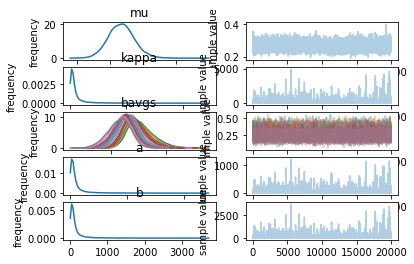

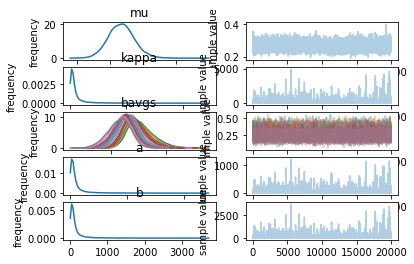

In [13]:
bb_fit.stan_plot()

In [14]:
# Check Rhat and ESS for pop'n params.
scalars = [bb_fit.mu, bb_fit.kappa]
print('*** Checks for convergence, mixing ***')
print('Rhat, ESS for scalar params:')
for param in scalars:
    print('    {0:12s}:  {1:6.3f}  {2:6.0f}'.format(param.name, param.Rhat, param.ess))


*** Checks for convergence, mixing ***
Rhat, ESS for scalar params:
    mu          :   1.000    7407
    kappa       :   1.006    1000


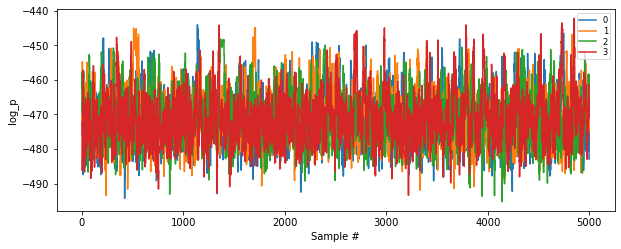

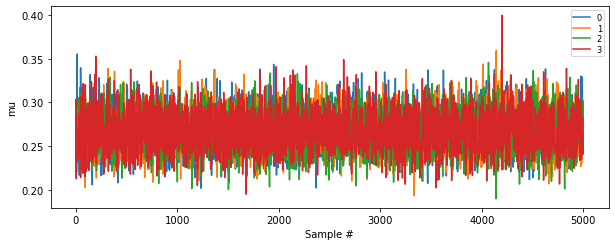

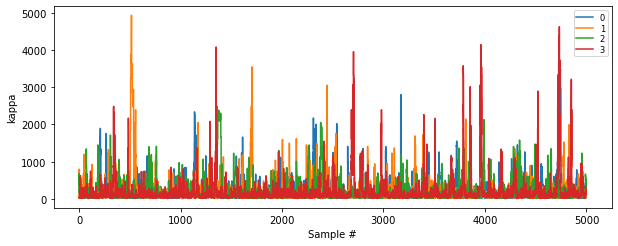

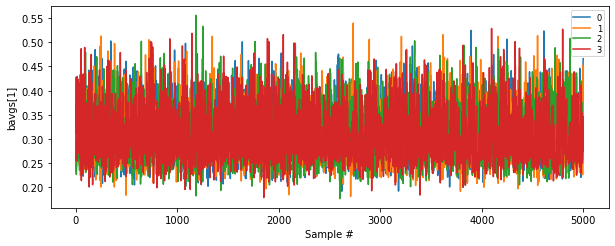

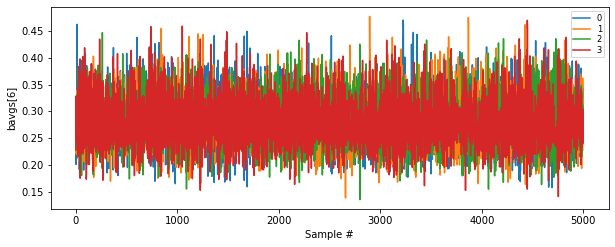

In [15]:
# Some trace plots:
bb_fit.log_p.trace()
bb_fit.mu.trace()
bb_fit.kappa.trace()
bb_fit.bavgs[0].trace()
bb_fit.bavgs[5].trace()

In [16]:
# Quick-and-dirty estimate of the posterior mode as the
# sample with the largest log_p.  *Note:*  This is not
# a great estimate in large-dimensional parameter spaces. 
i_max = bb_fit.log_p.thinned.argmax()
mu_hat = bb_fit.mu.thinned[i_max]
kappa_hat = bb_fit.kappa.thinned[i_max]
print('Rough estimate of ($\mu,\kappa$) mode:', mu_hat, kappa_hat)

Rough estimate of ($\mu,\kappa$) mode: 0.27877095900833504 3208.3404890031757


Text(0, 0.5, '$p(\\kappa|D)$')

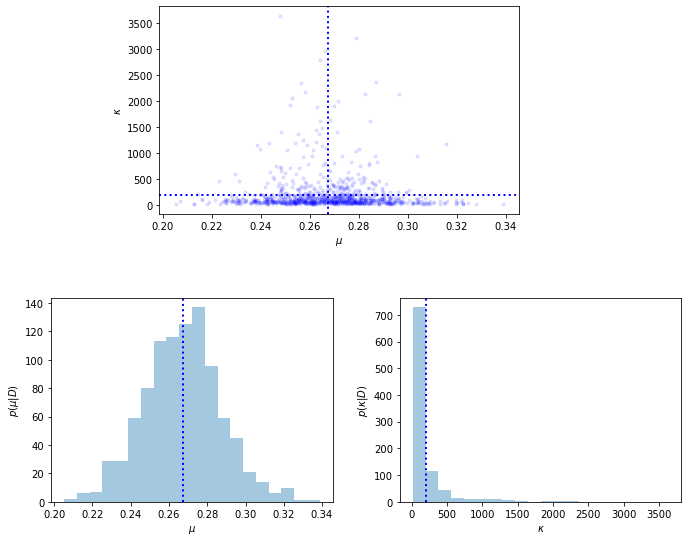

In [17]:
f = figure(figsize=(10,8))
subplots_adjust(bottom=.1, left=.1, right=.975, wspace=.24, )

# subplot(232)  # joint at mid-top
f.add_axes([.25, .6, .5, .36])
plot(bb_fit.mu.thinned, bb_fit.kappa.thinned, 'b.', alpha=.1)
# crosshair showing mean values:
xhair = { 'color' : 'b', 'linestyle' : ':' , 'linewidth' : 2}
axvline(bb_fit.mu.mean, **xhair)
axhline(bb_fit.kappa.mean, **xhair)
xlabel(r'$\mu$')
ylabel(r'$\kappa$')

subplot(223)  # marginal for mu bottom-left
hist(bb_fit.mu.thinned, 20, alpha=.4)
axvline(bb_fit.mu.mean, **xhair)
xlabel(r'$\mu$')
ylabel(r'$p(\mu|D)$')

subplot(224)  # marginal for sig bottom-right
hist(bb_fit.kappa.thinned, 20, alpha=.4)
axvline(bb_fit.kappa.mean, **xhair)
xlabel(r'$\kappa$')
ylabel(r'$p(\kappa|D)$')

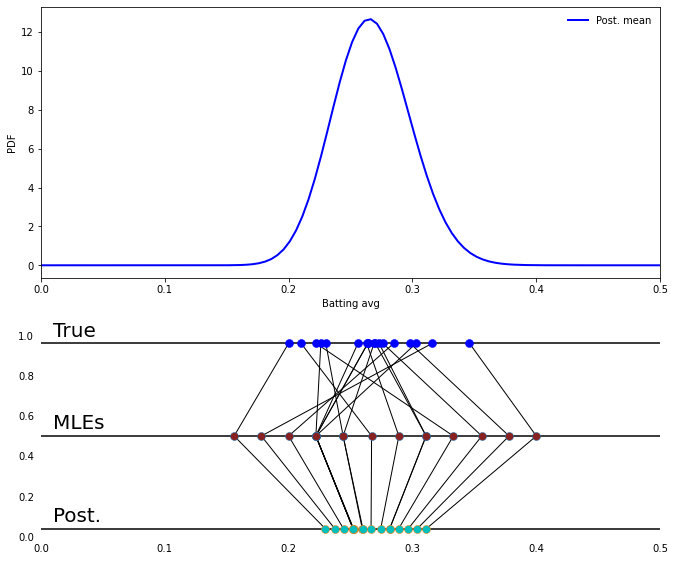

In [18]:
# Plot the best-fit pop'n dist'n and the point estimates,
# displaying shrinkage.

# Best-fit beta PDF:
avals = linspace(0., 1., 200)
# This uses the posterior mean (mu, kappa):
a, b = params2ab(bb_fit.mu.mean, bb_fit.kappa.mean)
beta_mean = stats.beta(a, b)
pdf_vals = beta_mean.pdf(avals)

# Collect the posterior mean batting avgs:
mbavgs = []
for i in range(n_players):
    mbavgs.append(bb_fit.bavgs[i].mean)
mbavgs = array(mbavgs)

# args are (x,y) for PDF, then "true", MLEs, posterior pt estimates
ax_pdf, ax_pts = shrinkage_plot(avals, pdf_vals, bbdata['Remainder'], bbdata['First45'],
              mbavgs, xlabel='Batting avg', pdf_label='Post. mean')

ax_pdf.set_xlim(0., 0.5)
ax_pts.set_xlim(0., 0.5);

In [19]:
mle_errs = bbdata['First45'] - bbdata['Remainder']
shrink_errs = mbavgs - bbdata['Remainder']
print('RMS errors:\n  MLEs: {:.4f}\n  Post: {:.4f}'.format(sqrt(mean(mle_errs**2)),
                                                          sqrt(mean(shrink_errs))))

RMS errors:
  MLEs: 0.0647
  Post: 0.0371
